### 利用dataframe将ret和factor因子的数据整合到一起
看出来ret里面有22年的数据,和timeeseries里list的长度263/12 是一致的！

In [95]:
from Codes.DataTransfrom import *

In [96]:
path = r'.\Data\factor'#96项因子所在路径
factorname = [x[1:-4] for x in os.listdir(path)]
print(len(factorname))
riskfree, timeseries, factor, timeseries2, index = datatransfrom(path)[0], datatransfrom(path)[1], datatransfrom(path)[2], datatransfrom2(path)[0], datatransfrom2(path)[1]

96


In [90]:
ret = pd.read_csv('./Data/final_return.csv')

print(timeseries[1].shape)
print(timeseries2[1].shape)
print('final_return info {}'.format(ret.shape))
print(len(timeseries))
print(len(timeseries2))
print('the len of factor was {}'.format(len(factor)))
print(f'index has the length of {len(index)}')


(311, 98)
(3571, 98)
final_return info (3571, 264)
263
263
the len of factor was 97
index has the length of 263


### data conclusion
总共有3571个股票，有76个因子，数据进一步处理后，在系列二里面只有311之股票（删除了月份收益不存在的数据行），在系列而里面有所有的股票。总共的年份为1997到2018年底，也就是（264/12=22年）

In [31]:
print((index[1]==False).sum())
print((index[1]==True).sum())

311
3260


In [32]:
print((index[2]==False).sum())
print((index[2]==True).sum())

313
3258


In [42]:
from Codes.StrategyConstruct import FC, output, output2, comboutput, ensemblenn
from sklearn.linear_model import LinearRegression,Lasso,ElasticNet,Ridge


## Mainfield 
FC 对于线性回归做T检测,对于不同的窗口。【3,6,12,18】<br>
>下面的代码为将以length为窗口的连续月份数据整合起来
$$
FINALm = pd.concat(timeseries[i:i + (length +1)], axis=0)
$$
## strategy construct
coef_应该是一次项系数，而intercept_应该是截距<br>
$$ 图1.1为FC函数的代码，看出FC封装函数：对每一个因子进行线性回归,以第length为窗口的数据进行回归，预测下一个月的收益 $$
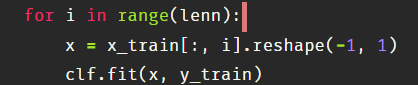$$图1.1$$ 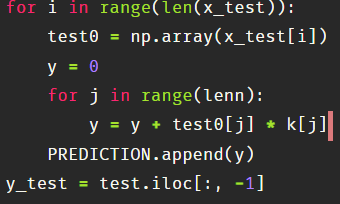 $$图1.2$$
<br>
<font face="黑体" color=red> 图1.2代码，此时进行long-short策略，看出来为卖空基于预测的最低10%的股票，买入最高回报的10%的股票
 </font>

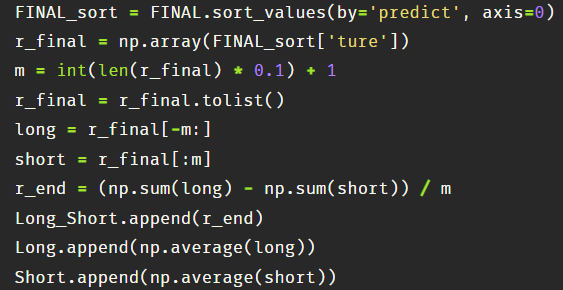

### here we test the output function
output function was kind of the smae structure as the fc function <br>
从图2看出来这里在预测后进行long-short strategy之后，代码接着计算回报的平均值，t-value，还有夏普比率，并且将结果放入csv文档，以预测模型名字命名
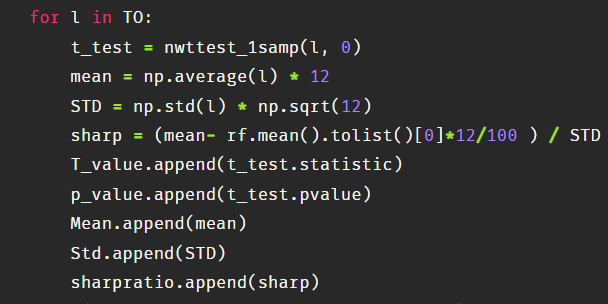 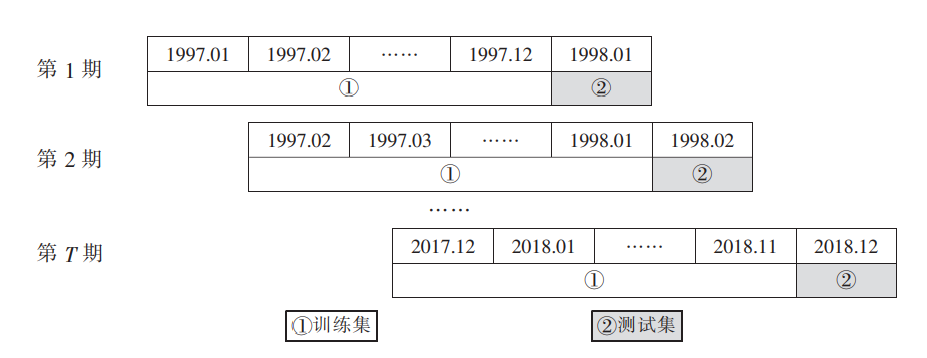$$图2$$
之后从图三的代码，看到此时分别利用fama三因子和五因子的数据对long，short，long-short strategy的得出的回报分别进行一个ols回归并且计算回归的t-value和他的alpha值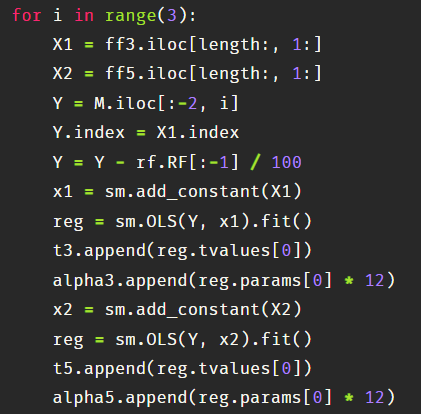$$图3$$



In [86]:
# test
length = 3
for i in range(len(timeseries) - length):
    print(i)
    FINALm = pd.concat(timeseries[i:i + (length +1)], axis=0)
    print(FINALm.shape)
    break   

0
(1254, 98)


### output2 function 
output和output2的结构基本是一样的，不同点在output用的timeseries，而output2用的time series2，系列二和以有着同样多的一个列，但是系列2的行数为3571，而系列一的行数只为300多，所以这里在图三,看出来此时模型对没有删除的数据喂入模型，后面的代码就和output相差不多
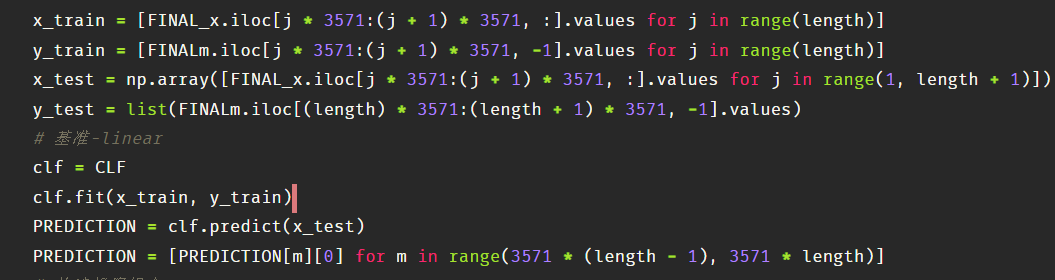$$图3$$
### comboutput and Ensemblelr
此时两个function同时使用将用删除了的数据拟合好的模型预测加上用未删除数据进行拟合的模型（RNN，LSTM，GRU）预测的结果汇总，取平均值得出最后结果。


### showtrasecfee
再加入交易费用后对模型重新进行t检验（其步骤和output function里面是一样的）
### dropimportant
这里表示在模型在提出96个因子里面的一个后模型再次拟合得出来的结果。

In [88]:
index[1]

0       False
1       False
2       False
3       False
4       False
        ...  
3566     True
3567     True
3568     True
3569     True
3570     True
Name: ret, Length: 3571, dtype: bool

## 缺陷
### 可视化
在跑入模型的时候删除print（i）而选择使用tqdm库函数.另外在output展现收益的时候这时候改用dataframe的形式，更加明了清晰。
效果如图4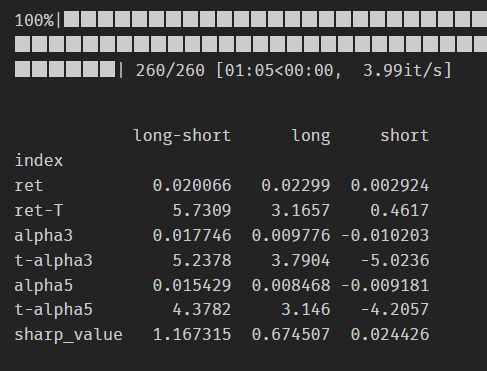$$XGRegressor$$
### 数据
看到模型跑数据时，每一个outputfunction进去都会造成数据多处理一遍，这样的可以单独将数据处理后return成x——train，ytrian，x-test，y-test。
### 代码缺陷
在进行模型拟合的时候，跑一次模型需要重新处理一边数据，这样增加了代码的长度，增加了代码运行的时间。
### LSTM缺陷
个人想法在于LSTM去单独拟合3个月为窗口的数据会导致模型的拟合效果很差，但是用36个月又会造成拟合速度过慢，毕竟LSTM不能属于time seires序列模型，不能使用parallel process展现GPU的处理能力，如果用到日内的量化是非常不合适。

In [21]:
import glob,os
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import scale
from Codes.NWttest import nwttest_1samp
import warnings
import gc
from tqdm import tqdm
def my_output(length,CLF,name,rf,timeseries):
    Long_Short = []
    Long = []
    Short = []
    for i in tqdm(range(len(timeseries) - (length))):
        # print(i)
        FINALm = pd.concat(timeseries[i:i + (length+1)], axis=0)
        FINALm = FINALm.fillna(0)#因子缺失值以0填充
        FINAL_X = FINALm.iloc[:, :-2]
        FINAL_x = scale(FINAL_X)
        final = pd.concat(timeseries[i:i + length], axis=0)
        x_train = FINAL_x[:len(final)]
        x_test = FINAL_x[len(final):]
        y_train = final.iloc[:, -1]
        test = timeseries[i + length]
        y_test = test.iloc[:, -1]
        # 基准-linear
        clf = CLF
        clf.fit(x_train, y_train)
        PREDICTION = clf.predict(x_test)
        # 构建投资组合
        prediction = pd.DataFrame(PREDICTION)
        r_predict = pd.DataFrame(PREDICTION, columns=['predict'])
        r_ture = pd.DataFrame(y_test)
        r_ture.columns = ['ture']
        r_ture.index = r_predict.index
        FINAL = pd.concat([r_predict, r_ture], axis=1)
        FINAL_sort = FINAL.sort_values(by='predict', axis=0)
        r_final = np.array(FINAL_sort['ture'])
        m = int(len(r_final) * 0.1) + 1
        r_final = r_final.tolist()
        long = r_final[-m:]
        short = r_final[:m]
        r_end = (np.sum(long) - np.sum(short)) / m
        Long_Short.append(r_end)
        Long.append(np.average(long))
        Short.append(np.average(short))
    T_value = []
    Mean = []
    p_value = []
    sharpratio = []
    Std = []
    TO = [Long_Short, Long, Short]
    for l in TO:
        t_test = nwttest_1samp(l, 0)
        mean = np.average(l) * 12
        STD = np.std(l) * np.sqrt(12)
        sharp = (mean- rf.mean().tolist()[0]*12/100 ) / STD
        T_value.append(t_test.statistic)
        p_value.append(t_test.pvalue)
        Mean.append(mean)
        Std.append(STD)
        sharpratio.append(sharp)
    a = {}
    a['long-short'],a['long'],a['short'] = [],[],[]
    a['long-short'].append(Mean[0]/12)   
    a['long'].append(Mean[1]/12)
    a['short'].append(Mean[2]/12)
    #T
    a['long-short'].append(str(round(T_value[0],4)))   
    a['long'].append(str(round(T_value[1],4)))
    a['short'].append(str(round(T_value[2],4)))
    A = pd.DataFrame(Long_Short, columns=['long-short'])
    B = pd.DataFrame(Long, columns=['long'])
    C = pd.DataFrame(Short, columns=['short'])
    M = pd.concat([A, B, C], axis=1)
    M.to_csv('..\output\\'+name+'.csv')
    ff3 = pd.read_csv('..\DataBase\\ff3.csv')
    ff5 = pd.read_csv('..\DataBase\\ff5.csv')
    alpha3 = []
    t3 = []
    t5 = []
    alpha5 = []
    for i in range(3):
        X1 = ff3.iloc[length:, 1:]
        X2 = ff5.iloc[length:, 1:]
        Y = M.iloc[:-2, i]
        Y.index = X1.index
        Y = Y - rf.RF[:-1] / 100
        x1 = sm.add_constant(X1)
        reg = sm.OLS(Y, x1).fit()
        t3.append(reg.tvalues[0])
        alpha3.append(reg.params[0] * 12)
        x2 = sm.add_constant(X2)
        reg = sm.OLS(Y, x2).fit()
        t5.append(reg.tvalues[0])
        alpha5.append(reg.params[0] * 12)
    a['long-short'].append(alpha3[0]/12)   
    a['long'].append(alpha3[1]/12)
    a['short'].append(alpha3[2]/12)
                      
    a['long-short'].append(str(round(t3[0],4)))   
    a['long'].append(str(round(t3[1],4)))
    a['short'].append(str(round(t3[2],4)))
                      
    a['long-short'].append(alpha5[0]/12)  
    a['long'].append(alpha5[1]/12)
    a['short'].append(alpha5[2]/12)
                      
    a['long-short'].append(str(round(t5[0],4)))   
    a['long'].append(str(round(t5[1],4)))
    a['short'].append(str(round(t5[2],4)))
                      
    a['long-short'].append(sharpratio[0])  
    a['long'].append(sharpratio[1])
    a['short'].append(sharpratio[2])    
    a['index'] = ['ret','ret-T','alpha3','t-alpha3','alpha5','t-alpha5','sharp_value']
    print(pd.DataFrame(a).set_index('index'))
    

In [23]:
# from Codes.StrategyConstruct import FC, output, output2, comboutput, ensemblenn
from xgboost.sklearn import XGBRegressor

DFN_params = {'learning_rate':[0.1, 0.1, 0.1, 0.001], 'batch': [300, 400, 300, 400]}
GBDT_params={'learning_rate':[0.1,0.1,0.1,0.1],'maxdepth':[2,3,2,2],'n_estimators':[100,100,100,100]}#XGBOOST与GBDT相同 此处共用
window=[3,12,24,36]
i = 0
my_output(window[i], XGBRegressor(n_estimators=GBDT_params['n_estimators'][i],max_depth=GBDT_params['maxdepth'][i], learning_rate=GBDT_params['learning_rate'][i]), 'XGBOOST' + str(window[i]), riskfree[i], timeseries)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 260/260 [01:05<00:00,  3.99it/s]

            long-short      long     short
index                                     
ret           0.020066   0.02299  0.002924
ret-T           5.7309    3.1657    0.4617
alpha3        0.017746  0.009776 -0.010203
t-alpha3        5.2378    3.7904   -5.0236
alpha5        0.015429  0.008468 -0.009181
t-alpha5        4.3782     3.146   -4.2057
sharp_value   1.167315  0.674507  0.024426


In [26]:
i=2
my_output(window[2], XGBRegressor(n_estimators=GBDT_params['n_estimators'][i],max_depth=GBDT_params['maxdepth'][i], learning_rate=GBDT_params['learning_rate'][i]), 'XGBOOST' + str(window[i]), riskfree[i], timeseries)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 239/239 [06:04<00:00,  1.53s/it]

            long-short      long     short
index                                     
ret           0.021929  0.025764  0.003836
ret-T           5.9225    3.2182      0.59
alpha3        0.018259  0.011052 -0.009223
t-alpha3        6.1448    4.3896   -5.1467
alpha5        0.015928  0.008587 -0.009374
t-alpha5        5.1571    3.2474   -4.6533
sharp_value   1.407799  0.746827  0.066743


In [24]:
PLS_params=[2,2,1,1]
from sklearn.cross_decomposition import PLSRegression
my_output(window[i], PLSRegression(PLS_params[i]), 'PLS' + str(window[i]), riskfree[i], timeseries)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 260/260 [00:09<00:00, 26.98it/s]

            long-short      long     short
index                                     
ret           0.015461  0.021507  0.006046
ret-T           4.4704    3.0184    0.9644
alpha3        0.012932  0.008687 -0.006478
t-alpha3        4.0412    3.4468   -3.4453
alpha5        0.011606  0.007758 -0.006068
t-alpha5         3.476    2.9095   -3.0063
sharp_value   0.918617  0.637738  0.138333


### model training conclusion
模型越好，其中long-short strategy的夏普比率也会越好，月收益越高（xgboost regressor比pls要复杂）<br>
窗口训练器越高，模型表现越好，带来的夏普比率更高，原因应该是数据量越多。    

#### 尝试构建tensorflow的DFN模型
对于mxnet训练模型不熟悉<br>
tensorflow更加方便<br>
<font face="黑体" color=red>图五上图为xgRegressor在窗口为3的拟合图，下图为在窗口为3时的tensorflow拟合好的图片，DFN的long-short夏普比率要好于XGregressor，如果改变DFN的训练loss fn或者增加windows和模型的depth效果应该会更好
 </font>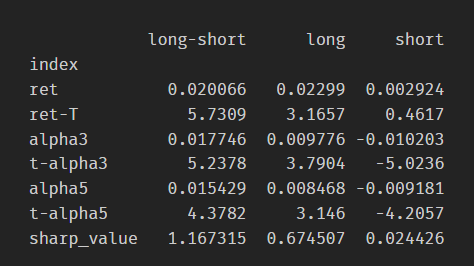$$图5 xgboost拟合图$$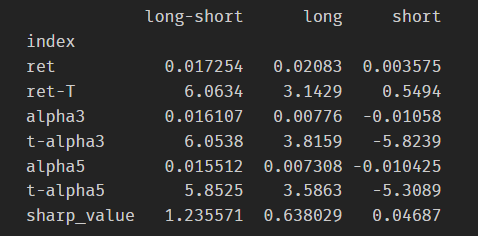$$图6 DFN拟合图$$


In [91]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
DFN = Sequential([
    Dense(96, input_shape=(96, ), activation='relu'),
    Dense(256, activation='relu'),
    Dense(1)
])
DFN.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])

In [93]:
Long_Short = []
Long = []
Short = []
for i in tqdm(range(len(timeseries) - (length))):
    # print(i)
    FINALm = pd.concat(timeseries[i:i + (length+1)], axis=0)
    FINALm = FINALm.fillna(0)#因子缺失值以0填充
    FINAL_X = FINALm.iloc[:, :-2]
    FINAL_x = scale(FINAL_X)
    final = pd.concat(timeseries[i:i + length], axis=0)
    x_train = FINAL_x[:len(final)]
    x_test = FINAL_x[len(final):]
    y_train = final.iloc[:, -1]
    test = timeseries[i + length]
    y_test = test.iloc[:, -1]
    # 基准-linear
    clf = DFN
    x_train=np.asarray(x_train).astype(np.float16)
    y_train=np.asarray(y_train).astype(np.float16)
    clf.fit(x_train, y_train, validation_split=0.001, batch_size=10, epochs=10, shuffle=True, verbose=0)
    PREDICTION = clf.predict(x_test)
    prediction = pd.DataFrame(PREDICTION)
    r_predict = pd.DataFrame(PREDICTION, columns=['predict'])
    r_ture = pd.DataFrame(y_test)
    r_ture.columns = ['ture']
    r_ture.index = r_predict.index
    FINAL = pd.concat([r_predict, r_ture], axis=1)
    FINAL_sort = FINAL.sort_values(by='predict', axis=0)
    r_final = np.array(FINAL_sort['ture'])
    m = int(len(r_final) * 0.1) + 1
    r_final = r_final.tolist()
    long = r_final[-m:]
    short = r_final[:m]
    r_end = (np.sum(long) - np.sum(short)) / m
    Long_Short.append(r_end)
    Long.append(np.average(long))
    Short.append(np.average(short))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 260/260 [24:24<00:00,  5.63s/it]


In [94]:
rf = riskfree[0]
name = 'DFN'
T_value = []
Mean = []
p_value = []
sharpratio = []
Std = []
TO = [Long_Short, Long, Short]
for l in TO:
    t_test = nwttest_1samp(l, 0)
    mean = np.average(l) * 12
    STD = np.std(l) * np.sqrt(12)
    sharp = (mean- rf.mean().tolist()[0]*12/100 ) / STD
    T_value.append(t_test.statistic)
    p_value.append(t_test.pvalue)
    Mean.append(mean)
    Std.append(STD)
    sharpratio.append(sharp)
a = {}
a['long-short'],a['long'],a['short'] = [],[],[]
a['long-short'].append(Mean[0]/12)   
a['long'].append(Mean[1]/12)
a['short'].append(Mean[2]/12)
#T
a['long-short'].append(str(round(T_value[0],4)))   
a['long'].append(str(round(T_value[1],4)))
a['short'].append(str(round(T_value[2],4)))
A = pd.DataFrame(Long_Short, columns=['long-short'])
B = pd.DataFrame(Long, columns=['long'])
C = pd.DataFrame(Short, columns=['short'])
M = pd.concat([A, B, C], axis=1)
M.to_csv('..\output\\'+name+'.csv')
ff3 = pd.read_csv('..\DataBase\\ff3.csv')
ff5 = pd.read_csv('..\DataBase\\ff5.csv')
alpha3 = []
t3 = []
t5 = []
alpha5 = []
for i in range(3):
    X1 = ff3.iloc[length:, 1:]
    X2 = ff5.iloc[length:, 1:]
    Y = M.iloc[:-2, i]
    Y.index = X1.index
    Y = Y - rf.RF[:-1] / 100
    x1 = sm.add_constant(X1)
    reg = sm.OLS(Y, x1).fit()
    t3.append(reg.tvalues[0])
    alpha3.append(reg.params[0] * 12)
    x2 = sm.add_constant(X2)
    reg = sm.OLS(Y, x2).fit()
    t5.append(reg.tvalues[0])
    alpha5.append(reg.params[0] * 12)
a['long-short'].append(alpha3[0]/12)   
a['long'].append(alpha3[1]/12)
a['short'].append(alpha3[2]/12)

a['long-short'].append(str(round(t3[0],4)))   
a['long'].append(str(round(t3[1],4)))
a['short'].append(str(round(t3[2],4)))

a['long-short'].append(alpha5[0]/12)  
a['long'].append(alpha5[1]/12)
a['short'].append(alpha5[2]/12)

a['long-short'].append(str(round(t5[0],4)))   
a['long'].append(str(round(t5[1],4)))
a['short'].append(str(round(t5[2],4)))

a['long-short'].append(sharpratio[0])  
a['long'].append(sharpratio[1])
a['short'].append(sharpratio[2])    
a['index'] = ['ret','ret-T','alpha3','t-alpha3','alpha5','t-alpha5','sharp_value']
print(pd.DataFrame(a).set_index('index'))

            long-short      long     short
index                                     
ret           0.017254   0.02083  0.003575
ret-T           6.0634    3.1429    0.5494
alpha3        0.016107   0.00776  -0.01058
t-alpha3        6.0538    3.8159   -5.8239
alpha5        0.015512  0.007308 -0.010425
t-alpha5        5.8525    3.5863   -5.3089
sharp_value   1.235571  0.638029   0.04687


### Factor and return series test

In [7]:
import numpy as np
import pandas as pd
import os
import gc
from Codes.NWttest import nwttest_1samp
import statsmodels.formula.api as smf

factorlist = os.listdir('./Data/returnseries/12')
rf=pd.read_csv('./Data/RF.csv')#无风险rf
rf12=rf.iloc[12:-1,:]
def trasecfee(feerate):
    '''
    :param feerate: 交易费率
    :return:不输出只打印结果
    '''
    for i in range(len(factorlist)):
        temp = pd.read_csv('./Data/returnseries/12/' + factorlist[i])
        long_short = np.array(temp['long-short'])
        afterLS = list(long_short - feerate*2)
        length = 12
        name = factorlist[i]
        T_value = []
        Mean = []
        p_value = []
        sharpratio = []
        Std = []
        TO = [afterLS]
        for l in TO:
            t_test = nwttest_1samp(l, 0, L=1)
            mean = np.average(l) * 12- rf12.mean().tolist()[0] * 12 / 100
            STD = np.std(l) * np.sqrt(12)
            sharp = (mean) / STD
            T_value.append(t_test.statistic)
            p_value.append(t_test.pvalue)
            Mean.append(mean)
            Std.append(STD)
            sharpratio.append(sharp)
        print(name, 'long-short')
        print('mean', Mean[0] / 12)
        print('t-statistic', '('+str(round(T_value[0],4))+')')
        ff3 = pd.read_csv('./Data/ff3.csv')
        ff5 = pd.read_csv('./Data/ff5.csv')
        A = pd.DataFrame(afterLS, columns=['long-short'])
        M = pd.concat([A], axis=1)
        alpha3 = []
        t3 = []
        t5 = []
        alpha5 = []
        for i in range(1):
            X1 = ff3.iloc[length:, 1:]
            X2 = ff5.iloc[length:, 1:]
            Y = M.iloc[:-2, i]
            Y.index = X1.index
            Y = Y - rf12.RF[:-1] / 100
            used1 = {'X': X1, 'Y': Y}
            reg = smf.ols(formula='Y~1+X', data=used1).fit(cov_type='HAC', cov_kwds={'maxlags': 1})
            t3.append(reg.tvalues[0])
            alpha3.append(reg.params[0] * 12)
            used2 = {'X': X2, 'Y': Y}
            reg = smf.ols(formula='Y~1+X', data=used2).fit(cov_type='HAC', cov_kwds={'maxlags': 1})
            t5.append(reg.tvalues[0])
            alpha5.append(reg.params[0] * 12)
        print('alpha-FF3', alpha3[0]/12)
        print('t-statistic', '('+str(round(t3[0],4))+')')
        print('alpha-FF5', alpha5[0]/12,)
        print('t-statistic','('+str(round(t5[0],4))+')')
        print('sharpe', sharpratio[0])
        gc.collect()
        print('*'*30)#分隔开不同收益序列


def showtrasecfee(transectionfee):
    '''
    :param transectionfee: 交易费用比例
    :return: 无返回直接打印交易费用调整后的结果
    '''
    trasecfee(transectionfee)# 方便调用

In [14]:
"""
@description:
    在获取各个算法构建多空组合月度收益序列后，对各个收益序列与OLS回归（benchmark）
    和DFN（表现最好的深度算法）序列是否存在显著差异进行NW-T检验
"""

import glob,os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

#
def returnseriestest(length):
    path = r'.\Data\returnseries'+'\\'+str(length)
    file = glob.glob(os.path.join(path, "*.csv"))
    ols = pd.read_csv(path+'\\OLS'+str(length)+'.csv')
    dfn=pd.read_csv(path+'\\DFN'+str(length)+'.csv')
    k = []  # 每个算法一个df
    for i in range(len(file)):
        k.append(pd.read_csv(file[i]))
    #OLS与其他算法区别
    for i in range(len(k)):
        t = []
        t1 = nwttest_1samp(k[i].iloc[:, 1] - ols['long-short'], 0)
        t.append(t1.statistic)
        t2 = nwttest_1samp(k[i].iloc[:, 2] - ols['long'], 0)
        t.append(t2.statistic)
        t3 = nwttest_1samp(k[i].iloc[:, 3] - ols['short'], 0)
        t.append(t3.statistic)
        print('ols-'+file[i][27:-4], t)
    #DFN与其他算法区别
    for i in range(len(k)):
        t = []
        t1 = nwttest_1samp(-k[i].iloc[:, 1] + dfn['long-short'], 0)
        t.append(t1.statistic)
        t2 = nwttest_1samp(-k[i].iloc[:, 2] + dfn['long'], 0)
        t.append(t2.statistic)
        t3 = nwttest_1samp(-k[i].iloc[:, 3] + dfn['short'], 0)
        t.append(t3.statistic)
        print('dfn-'+file[i][27:-4], t)
    return


In [18]:
 returnseriestest(12)

ols-2 [3.6477486675483513, 4.260066627300523, -1.9629432860730018]
ols-ticNet12 [1.5267692510477346, 2.1661653773255654, 0.14306375623349415]
ols-NN12 [1.4915822432075903, 1.6925831116210182, -0.7537636327680751]
ols-mble12 [6.509159103684662, 5.2342945481161856, -4.820806367988882]
ols- [1.013382807913608, 1.8043807911924767, 0.020076733691600263]
ols-12 [3.0821129141083836, 2.3412533389828942, -2.664618846375669]
ols-o12 [0.7950349396727789, 1.4247004280809101, 0.4538811926060518]
ols-12 [2.554750827655575, 3.5155756429012484, -0.34509118643113873]
ols-2 [nan, nan, nan]
ols-2 [1.4787566665765155, 1.133209014432692, -1.3566401058208444]
ols-e12 [1.3761006019037378, 1.4411885639975137, -0.8061211854126878]
ols-2 [0.3742052168107068, 1.1669995498827967, 0.6897329894845458]
ols-2 [2.4288002429028004, 2.5459359937472064, -1.1564685774899657]
ols-OST12 [3.2382107396303326, 2.637655033281141, -2.7589883275424367]
dfn-2 [nan, nan, nan]
dfn-ticNet12 [3.2768081716201665, 3.5755452389631732, -2

In [20]:
showtrasecfee(0.005)


DFN12.csv long-short
mean 0.015707341899573356
t-statistic (5.5077)
alpha-FF3 0.013520858643216874
t-statistic (4.6168)
alpha-FF5 0.011419228603718336
t-statistic (4.6262)
sharpe 1.2311480708878342
******************************
ElasticNet12.csv long-short
mean 0.009092311860430665
t-statistic (3.6192)
alpha-FF3 0.007750843082822219
t-statistic (2.6668)
alpha-FF5 0.006967285253471153
t-statistic (2.608)
sharpe 0.747412762299763
******************************
EN-ANN12.csv long-short
mean 0.011282738899623663
t-statistic (4.6485)
alpha-FF3 0.010653167321652288
t-statistic (3.9827)
alpha-FF5 0.008730443788793785
t-statistic (3.404)
sharpe 0.9586177819232026
******************************
Ensemble12.csv long-short
mean 0.017767877432854014
t-statistic (6.1618)
alpha-FF3 0.016693476959957133
t-statistic (5.5394)
alpha-FF5 0.01553664126022423
t-statistic (5.6248)
sharpe 1.3908280446544037
******************************
FC12.csv long-short
mean 0.010669536608189194
t-statistic (3.3469)
alpha-

### 扩展 （基于博弈论的shape value）
理论:在论文里面说到，有很多因子会影响到股票的收益，但是实际上不知道哪一个因子的影响是怎么样的。我这里采用xgboost（模型的解释力度比其他的模型强）


In [68]:
length1 =64
from sklearn.preprocessing import scale
i = len(timeseries) - (length1)-1
FINALm = pd.concat(timeseries[i:i + (length1+1)], axis=0)
FINALm = FINALm.fillna(0)#因子缺失值以0填充
FINAL_X = FINALm.iloc[:, :-2]
FINAL_x = scale(FINAL_X)
final = pd.concat(timeseries[i:i + length1], axis=0)
x_train = FINAL_x[:len(final)]
x_test = FINAL_x[len(final):]
y_train = final.iloc[:, -1]
test = timeseries2[i + length1]
y_test = test.iloc[:, -1]


In [69]:
y_train

0      -0.033503
2          0.009
3      -0.039474
4      -0.051643
5       0.081509
          ...   
3566   -0.107456
3567   -0.124859
3568   -0.237351
3569   -0.136442
3570   -0.056752
Name: ret, Length: 155845, dtype: object

In [70]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
path = r'.\Data\factor'#96项因子所在路径
feature_names = [x[1:-4] for x in os.listdir(path)]


In [77]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split
i = 3
GBDT_params={'learning_rate':[0.1,0.1,0.1,0.1],'maxdepth':[2,3,2,2],'n_estimators':[100,100,100,100]}#XGBOOST与GBDT相同 此处共用
model_regressor = XGBRegressor(n_estimators=GBDT_params['n_estimators'][i],max_depth=GBDT_params['maxdepth'][i], 
             learning_rate=GBDT_params['learning_rate'][i])
train_X, val_X, train_y, val_y = train_test_split(x_train, y_train, random_state=1)
model_regressor.fit(train_X, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

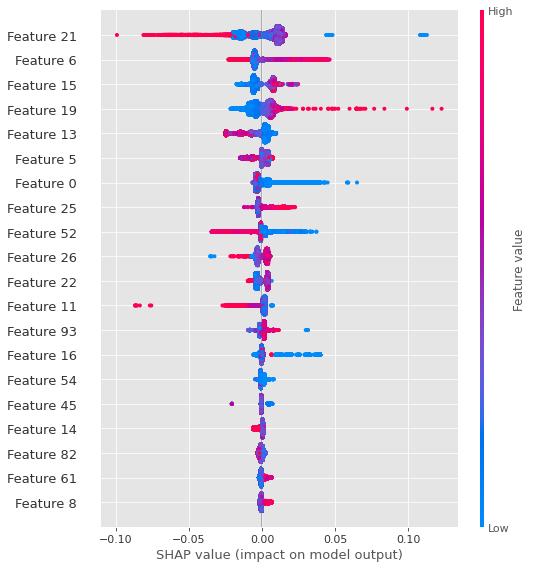

In [83]:
import shap  # package used to calculate Shap values
plt.style.use('ggplot')
# Create object that can calculate shap values
explainer = shap.TreeExplainer(model_regressor)
# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(val_X)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, val_X)

In [84]:
feature_names[19]

'0aeavol'

In [85]:
feature_names[21]

'2mom12'

In [87]:
feature_names[6]

'7retvol'

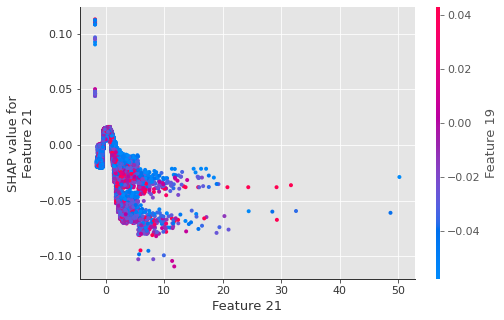

In [94]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(model_regressor)

# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(x_train)

# make plot.
shap.dependence_plot('Feature 21', shap_values, x_train, interaction_index="Feature 19")

#### 结论
这里说明了0aeavol对月收益具有正相关，2mom12（应该是12个月的momentum）对于收益具有负相关，7retvol对手以具有负相关。
从下图可以看出来。第二个图说明2mom12和0aeavol并无特别大的关系。